In [ ]:
#////////////////variables to set/////////////////////////
# /!\
#/_!_\ to change according to computer

#main path to data, change according to environment
root_dir = r'E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii'
dir_to_save = r'C:\Users\Dylan\Desktop\UdeM_E22\Projet_Ivado_rainvillelab\results_GLM\testing_scripts'

#SERVEUR elm

#root_dir = r'/data/rainville/dylan_projet_ivado_decodage/Nii'
#dir_to_save = r'/data/rainville/dylan_projet_ivado_decodage/results/GLM_1st_level_each_shock'

# /!\
#/_!_\ to change according to computer
#local
timestamps_root_path = r'C:\Users\Dylan\Desktop\BAC_neurocog\UM_H22\PSY3008\times_stamps'

 #elm
#timestamps_path_root = r'/data/rainville/dylan_projet_ivado_decodage/time_stamps'
many_runs=True

In [ ]:
import numpy as np
import os
import pandas as pd
import glob
import nibabel as nib
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
from A_data_prep import function_code as A_data_prep
from B_design_matrix import function_DM as B_design_matrix
from C_contrasts import function_contrasts as contrast

In [ ]:
#==============================================================
#store all subject's name in a list
ls_subj_name = [subject for subject in os.listdir(root_dir)]

#make a list for all the subject's path to data
ls_subj_path  = [os.path.join(root_dir,subject) for subject in os.listdir(root_dir)]


for subj_path in ls_subj_path:

    #=================
    subj_name = os.path.basename(os.path.normpath(subj_path)) #extract last part of subj_path to get subject's name
    print(subj_name + ' = subj_name')
    #----path preparation---
    #res_folder = input('Enter the name under which to create ')
    #Creating a dir to save, only if it doesn't exists
    if os.path.exists(os.path.join(dir_to_save,subj_name)) is False:

        os.mkdir(os.path.join(dir_to_save,subj_name))
    else :
        pass
    #=================
    #looking for the regressors' file, which starts with 'APM' and read it as csv
    movement_reg_name = [i for i in os.listdir(subj_path) if i.startswith('APM')]
    mvmnt_reg_path = os.path.join(subj_path,movement_reg_name[0])#movement_reg_name[0] because there's only one item in the list
    df_mvmnt_reg_full = pd.read_csv(mvmnt_reg_path, sep= '\s+', header=None)#full because we'll split it later according to condition

    #=================
    #file names that contains the fMRI volumes.
    str_analgesia ='Analgesia'
    str_hyper = 'Hyperalgesia'

    if many_runs:
        design_matrices = []
        all_fmri_timeseries = []


In [ ]:
 #Main loop that will go over the condition's file, and generate a design matrix (DM) and a contrast according to the condition
    #In that loop, a Timestamps,a DM name,a mouvement regressors dataframe, a DM and statistical maps will be generated and saved
    for condition_file in [i for i in os.listdir(subj_path) if str_analgesia in i or str_hyper in i ]:
        print(condition_file + ' = condition_file')

        #-------Extracting fMRI volumes-------
        data_path = os.path.join(subj_path,condition_file) #path to the data such as : /subj_01/02-Analgesia/<all nii files>
        subj_volumes= glob.glob(os.path.join(data_path,'sw*'))#extracting all the nii files that start with sw
        print('{} NII files in path {} for subject {}'.format(len(subj_volumes),data_path,subj_name))
        print('lenght of movement regesssor df : {}'.format(len(df_mvmnt_reg_full)))

        #-------Extracting timestamps--------
        timestamps = A_data_prep.get_timestamps(data_path, subj_name,timestamps_root_path,return_df =True)
        timestamps.sort_values(by=['onset'])

        #----condition and design matrix name-----
        condition, DM_name = A_data_prep.if_str_in_file(condition_file,subj_name)#checks if str_analgesia or str_hyper is in condition_file

        #-------movement regessors--------
        if condition == 'HYPO':
             mvmnt_reg_df = A_data_prep.split_reg_upper(df_mvmnt_reg_full,len(subj_volumes))
        elif condition == 'HYPER':
            mvmnt_reg_df = A_data_prep.split_reg_lower(df_mvmnt_reg_full,len(subj_volumes)) #splitting either the first half or lower half of the mvmnt regressor df according to condition (analg/hyper)

        #------DESIGN MATRIX------
        if os.path.exists(os.path.join(dir_to_save, subj_name, DM_name)) is False:#check if the DM already exists in path to we save computing time

            design_matrix, fmri_time_series = B_design_matrix.create_DM(subj_volumes, timestamps, DM_name, mvmnt_reg_df)

            #----------SAVING OUTPUTS------------
            #saving design_matrix and time series
            design_matrix.to_csv(os.path.join(dir_to_save,subj_name,DM_name), index = False)
            fmri_img_name = subj_name + '_' + condition + '_fmri_time_series.nii'
            nib.save(fmri_time_series, os.path.join(dir_to_save,subj_name,fmri_img_name))

        else:
            print('Design matrix in condition _{}_  is already existant for : {} '.format(condition, subj_name))
            design_matrix = pd.read_csv(os.path.join(dir_to_save, subj_name, DM_name))
            fmri_img_name = subj_name + '_' + condition + '_fmri_time_series.nii'
            fmri_time_series = nib.load(os.path.join(dir_to_save,subj_name, fmri_img_name))

        #-------Plot option-------
        #Uncomment to plot the design matrix as it's generated
        #from nilearn.plotting import plot_design_matrix
        #plot_design_matrix(design_matrix)
        #plt.show()

        #-------CONTRAST-------
        done_file_name = 'done_contrast_' + condition + '.txt' #define a done_file name to check if it  already exists in file

        if many_runs: #if many runs, the contrast function is delayed out of this for loop to append the DM and time series for all runs
            design_matrices.append(design_matrix)
            all_fmri_timeseries.append(fmri_time_series)
            condition = 'combined_runs'
        elif os.path.exists(os.path.join(dir_to_save,subj_name,done_file_name)) == False : #if done_file doesn't exist

            #contrast for a single shock activation map
            #beta_map = contrast.glm_contrast_1event(design_matrix, os.path.join(dir_to_save,subj_name), subj_name, fmri_time_series, run = condition)

            #contrast for all shocks activation map, one for each design matrix will be made
            beta_map = contrast.glm_contrast_all_shocks(design_matrix, os.path.join(dir_to_save,subj_name), subj_name, fmri_time_series, run = condition)

            #-------SAVING-------
            #write done_contrast_hyper/hypo to keep track of what has been computed
            save_done_file(os.path.join(dir_to_save,subj_name,done_file_name))

        else:
            print('Contrast : _{}_ has already been done for subject : {} '.format(condition, subj_name))

    if many_runs:

        beta_map = contrast.glm_contrast_runs_N_shocks(design_matrices,all_fmri_timeseries, os.path.join(dir_to_save,subj_name), subj_name, run_name = condition)
        done_file_name = 'done_contrast_' + condition + '.txt'
        contrast.save_done_file(os.path.join(dir_to_save,subj_name,done_file_name))


APM_02_H2 = subj_name
02-Hyperalgesia = condition_file
388 NII files in path E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii\APM_02_H2\02-Hyperalgesia for subject APM_02_H2
lenght of movement regesssor df : 760
Design matrix in condition _HYPER_  is already existant for : APM_02_H2 
03-Analgesia = condition_file
372 NII files in path E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii\APM_02_H2\03-Analgesia for subject APM_02_H2
lenght of movement regesssor df : 760
Design matrix in condition _HYPO_  is already existant for : APM_02_H2 
COMPUTING GLM for all the runs, for subject APM_02_H2


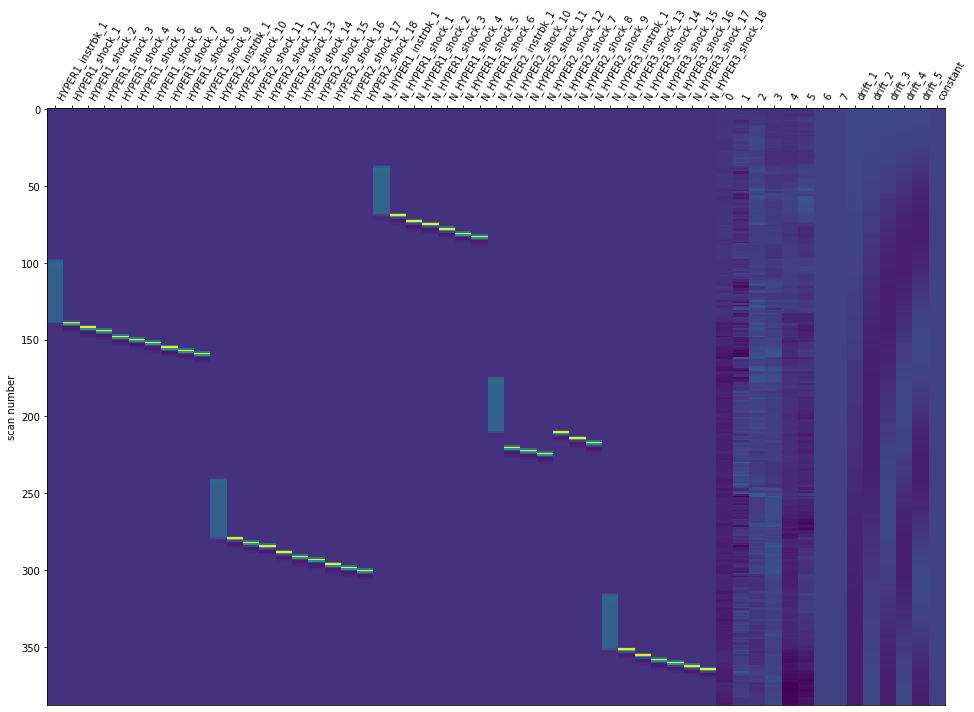

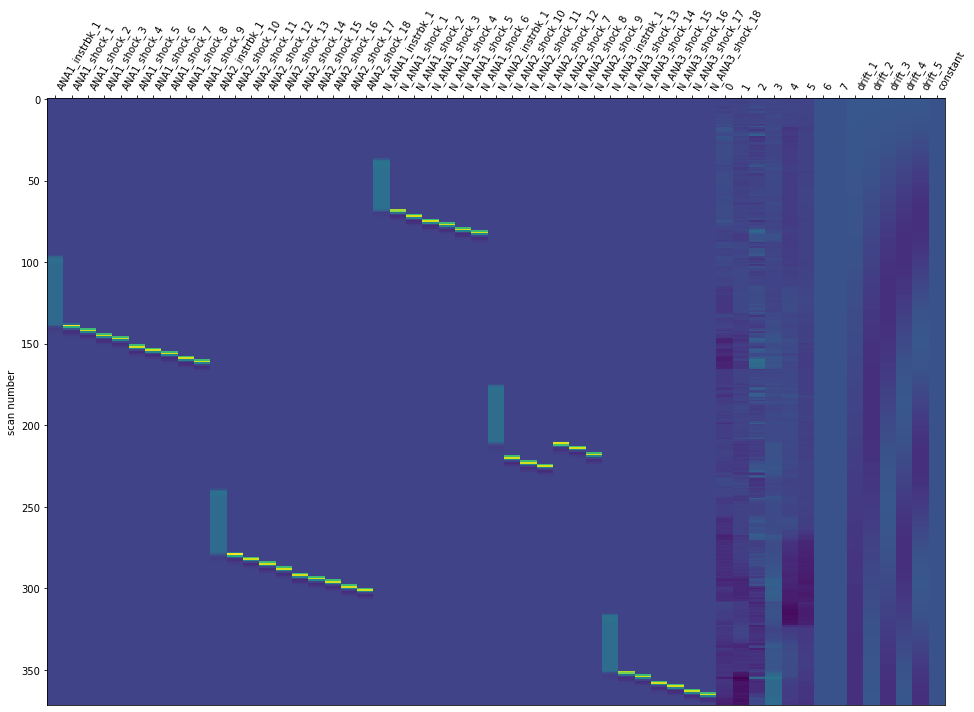

FirstLevelModel(high_pass=0.00233645, hrf_model='spm', t_r=3)
will add  ANA1_shock_1
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_2
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_3
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_4
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_5
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_6
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_7
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_8
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_sho

C:\Users\Dylan\AppData\Roaming\Python\Python310\site-packages\nilearn\glm\first_level\first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


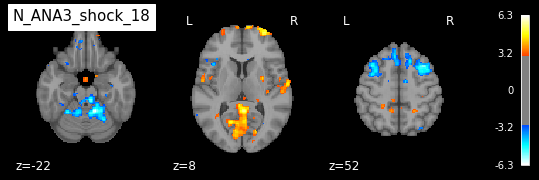

Have saved beta_map as a : <class 'nibabel.nifti1.Nifti1Image'> , having shape : (91, 109, 91) , under name : beta_map_APM_02_H2_combined_runs_Neut_shocks


AttributeError: module 'C_contrasts.function_contrasts' has no attribute 'save_done_file'

In [2]:
import main_script_1st_level

In [9]:
keys = 'N_Ana_shock'

        #if the key is str, in order to exclude the drifts and other parameters
if type(keys) is str:

    ls_string_interest = ['N', 'shock']
    word1 = 'N'
    word2 = 'shock'
    if word1 in keys and word2 in keys:
        print('will add ', keys)
        print('because ls_string_interest[0] is in keys',ls_string_interest[0] in keys)
        print('because ls_string_interest[1] is in keys',ls_string_interest[1] in keys)

    else:
        print('no')#in the contrast vector for all regressors of interest
        

will add  N_Ana_shock
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True


In [ ]:
 actual_key_name = key_list[indx]
                ls_keys.append(keys)#extract the actual regressor/key name with the index position
                contrast_vector += identity_matrix[:, indx] #sum of the contrast vector with the identity matrix column to stack the ones
                 